# Imports

In [655]:
import numpy as np
import matplotlib.pyplot as plt
import math

from skimage.io import imread
from bresenham import bresenham

from skimage.color import rgb2gray

# Global variables

In [656]:
STEP = 1 # step of emitter in degrees
NUMBER_OF_DETECTORS = 90
DETECTORS_RANGE = 90 # degrees

RANGE = 360 # iterations - whole cirlce
RADIUS = int() # initialized and compute after image is loaded

SOURCE = "photos/Kolo.jpg"

# Main

In [657]:
def main():
    image = rgb2gray(imread(SOURCE))
    display_image(image, "Zdjęcie wejściowe")

    global RADIUS     
    RADIUS = int(image.shape[0] / 2) - 1
    
    sinogram = make_sinogram(image)
    normalized_sinogram = normalize(sinogram)
    display_image(normalized_sinogram, "Sinogram")
    
    reverse_sinogram = make_reverse_sinogram(sinogram, [image.shape[0], image.shape[1]])
    reverse_sinogram = reverse_sinogram[int(image.shape[0] / 4):int(3 * image.shape[0] / 4), int(image.shape[1] / 4):int(3 * image.shape[1] / 4)]

    normalized_reverse_sinogram = normalize(reverse_sinogram)
    display_image(reverse_sinogram, "Reverse Sinogram")

# Functions

### Display Image

In [658]:
def display_image(image, title):
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()

### Emiter position

In [659]:
def set_emitter_position(angle):
    x = RADIUS * math.cos(math.radians(angle)) + RADIUS
    y = RADIUS * math.sin(math.radians(angle)) + RADIUS
    return [round(x), round(y)]

### Detectors positions

In [660]:
def set_detectors_positions(angle):
    result = list()
    
    for i in range(NUMBER_OF_DETECTORS): # cos by tu trzeba uproscic, ale chyba dziala
        x = RADIUS * math.cos(math.radians(angle) + math.pi - (math.radians(DETECTORS_RANGE) / 2) 
                         + i * (math.radians(DETECTORS_RANGE) / (NUMBER_OF_DETECTORS - 1)))
        y = RADIUS * math.sin(math.radians(angle) + math.pi - (math.radians(DETECTORS_RANGE) / 2) 
                         + i * (math.radians(DETECTORS_RANGE) / (NUMBER_OF_DETECTORS - 1)))
        result.append([round(x + RADIUS), round(y + RADIUS)])
    
    return result

### All positions

In [661]:
def set_positions():
    emitters = list()
    detectors = list()
    
    for i in range (0, RANGE, STEP):
        emitters.append(set_emitter_position(i))
        detectors.append(set_detectors_positions(i))
        
    return emitters, detectors

### Sinogram

In [662]:
def make_sinogram(image):
    emitters, detectors = set_positions()
    sinogram = np.zeros([len(emitters), NUMBER_OF_DETECTORS])

    for i in range(len(emitters)):
        for j in range(len(detectors[i])):
            line = bresenham(emitters[i][0], emitters[i][1], detectors[i][j][0], detectors[i][j][1])
            
            for point in line:
                sinogram[i, j] += image[point[0], point[1]]
            
    return sinogram 

### Reverse Sinogram

In [663]:
def make_reverse_sinogram(image, dimensions):
    emitters, detectors = set_positions()
    
    reverse_sinogram = np.zeros(dimensions)
    reverseCounter = np.zeros(dimensions)
    for i in range(len(emitters)):
        for j in range(len(detectors[i])):
            line = bresenham(emitters[i][0], emitters[i][1], detectors[i][j][0], detectors[i][j][1])
            
            for point in line:
                reverse_sinogram[point[0], point[1]] += image[i][j]
                reverseCounter[point[0], point[1]] += 1
    
    #Ocb?
    for i in range(len(reverse_sinogram)):
        for j in range(len(reverse_sinogram[i])):
            if reverseCounter[i][j] != 0:
                reverse_sinogram[i][j] = reverse_sinogram[i][j] / reverseCounter[i][j]
                
    return reverse_sinogram

### Normalize

In [664]:
def normalize(image):
    min_value = np.min(image)
    max_value = np.max(image)
    for i in range(len(image)):
        for j in range(len(image[i])):
            image[i, j] = (image[i, j] - min_value) / (max_value - min_value) * 255   
    return image

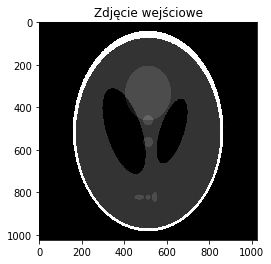

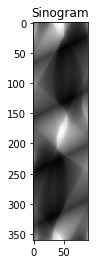

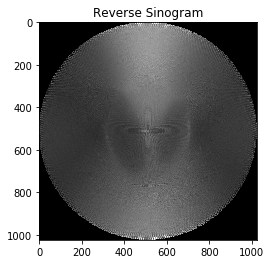

In [665]:
main()